In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [46]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


## Load in data

In [108]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = read_tracer_and_zos_from_budget(datadir("model/tracers_sigma2_1p5/CM4Xp125_ssp585_tracers_sigma2_2020-2024.zarr"))

/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/budgets_sigma2_1p5/CM4Xp125_budgets_sigma2_2020-2024.zarr


In [110]:
z_i = np.arange(-6500, 251, 250)
z_l = (z_i[1:] + z_i[0:-1]) / 2
# ds = ds.assign_coords({"z_l": z_l, "z_i":z_i})
ds_remap_uni = remap_sigma_to_depth(ds, z_i = z_i, z_l = z_l)
ds_loc_uni = ds_remap_uni.isel(xh = 100, yh = 100).compute()

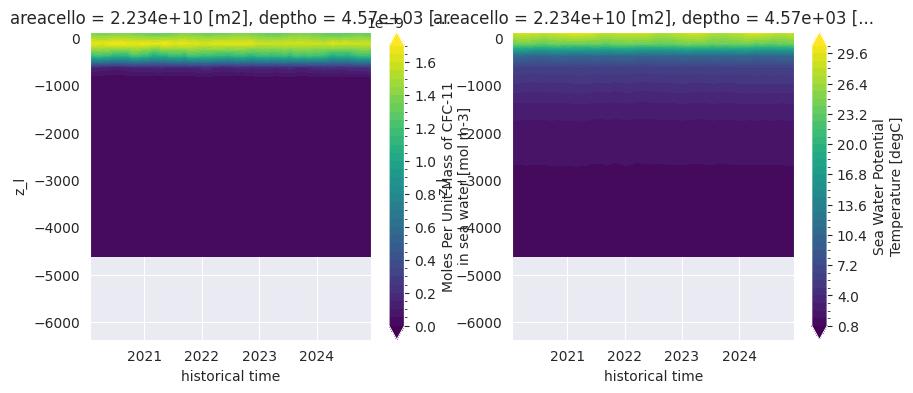

In [111]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ds_loc_uni.cfc11.T.plot.contourf(ax = ax[0], extend = "both", levels = 40)
ds_loc_uni.thetao.T.plot.contourf(ax = ax[1], extend = "both", levels = 40)

In [112]:
ds_remap = remap_sigma_to_depth(ds)
ds_loc = ds_remap.isel(xh = 100, yh = 100).compute()

no z_i provided
using a default setup
N = 35; H = 6500 meters; eta = 25 meters


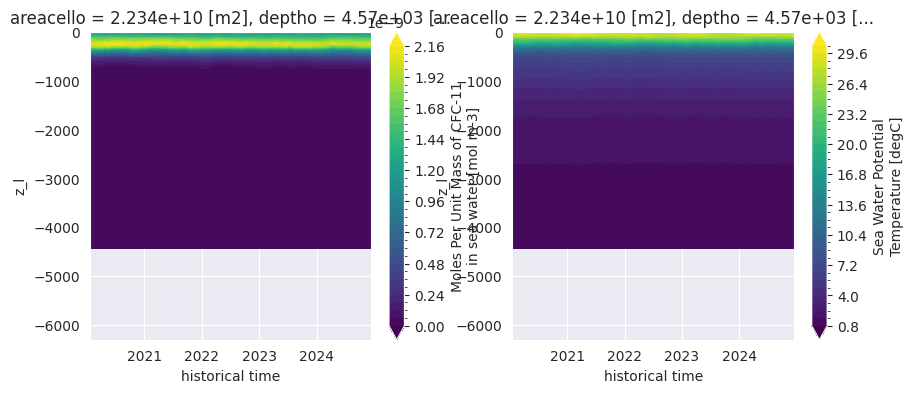

In [113]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ds_loc.cfc11.T.plot.contourf(ax = ax[0], extend = "both", levels = 40)
ds_loc.thetao.T.plot.contourf(ax = ax[1], extend = "both", levels = 40)

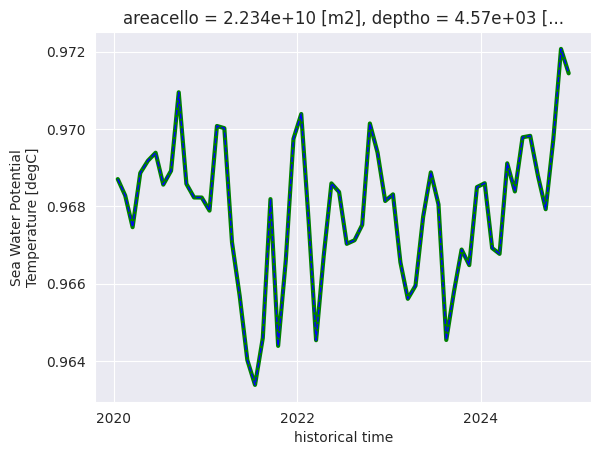

In [15]:
ds_loc_uni["thetao"].sel(z_l = -4000, method = "nearest").plot(c = "g", lw = 3)
ds_loc["thetao"].sel(z_l = -4000, method = "nearest").plot(c = "b", lw = 1, linestyle = "--")

NameError: name 'z_depth' is not defined

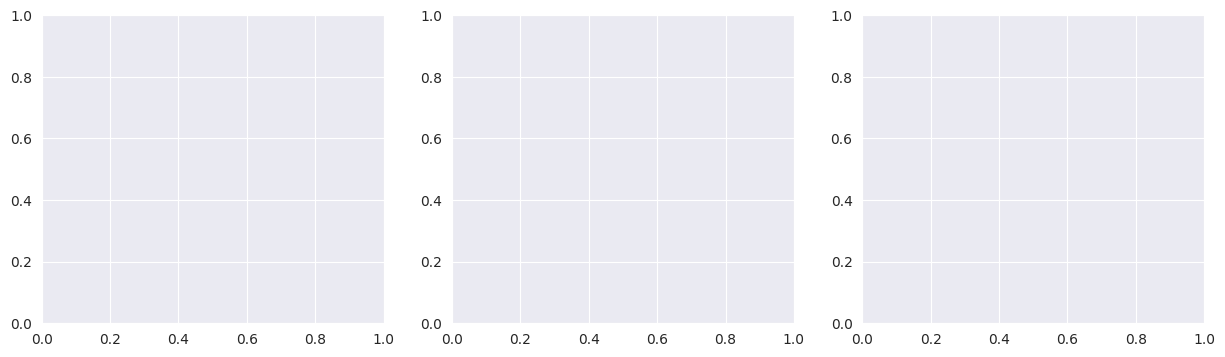

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

z_depth.plot.contourf(ax = ax[0])
sigma2_depth.plot.contourf(ax = ax[1])
(np.abs(z_depth - sigma2_depth) / z_depth).where(z_depth != 0.0).plot.contourf(ax = ax[2])

In [13]:
cfc11_mass_by_depth = grid.transform((ds["cfc11"] * ds["thkcello"]).fillna(0.), 'Z', z_i,
                                   target_data=ds["z"], method='conservative')
layer_thickness_by_depth = grid.transform(ds["thkcello"].fillna(0.), 'Z', z_i,
                                   target_data=ds["z"], method='conservative')

cfc11_by_depth = (cfc11_mass_by_depth / layer_thickness_by_depth).where(layer_thickness_by_depth != 0.0)

cfc11_by_depth_y1 = cfc11_by_depth.isel(time = -1).compute()
cfc11_by_depth_CM4Xutils_y1 = ds_remap["cfc11"].isel(time = -1).compute()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


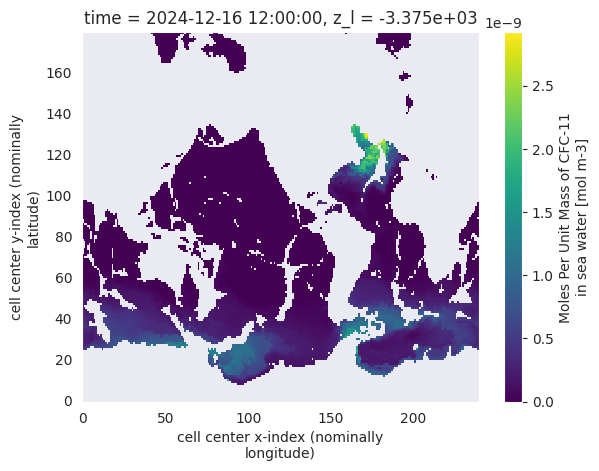

In [14]:
cfc11_by_depth_CM4Xutils_y1.isel(z_l = -15).plot()

Text(0.5, 1.0, 'Difference')

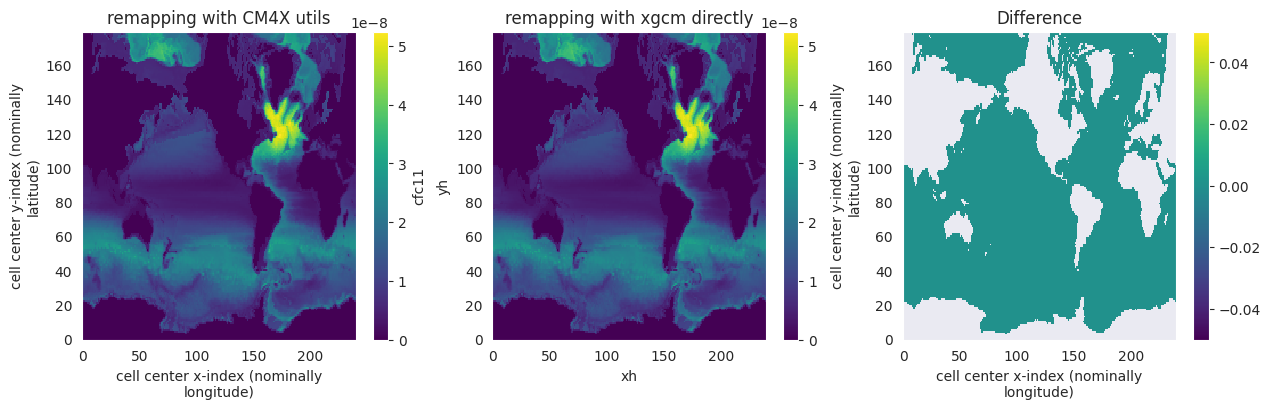

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

cfc11_by_depth_CM4Xutils_y1.sum("z_l", skipna = True).plot(ax = ax[0])
ax[0].set_title("remapping with CM4X utils")
cfc11_by_depth_y1.sum("z").plot(ax = ax[1])
ax[1].set_title("remapping with xgcm directly")

# sigma2_depth.plot.contourf(ax = ax[1])
difference = np.abs(cfc11_by_depth_CM4Xutils_y1.sum("z_l") - cfc11_by_depth_y1.sum("z"))
(difference/ cfc11_by_depth_y1.sum("z")).plot(ax = ax[2])
ax[2].set_title("Difference")


Text(0.5, 1.0, 'Difference')

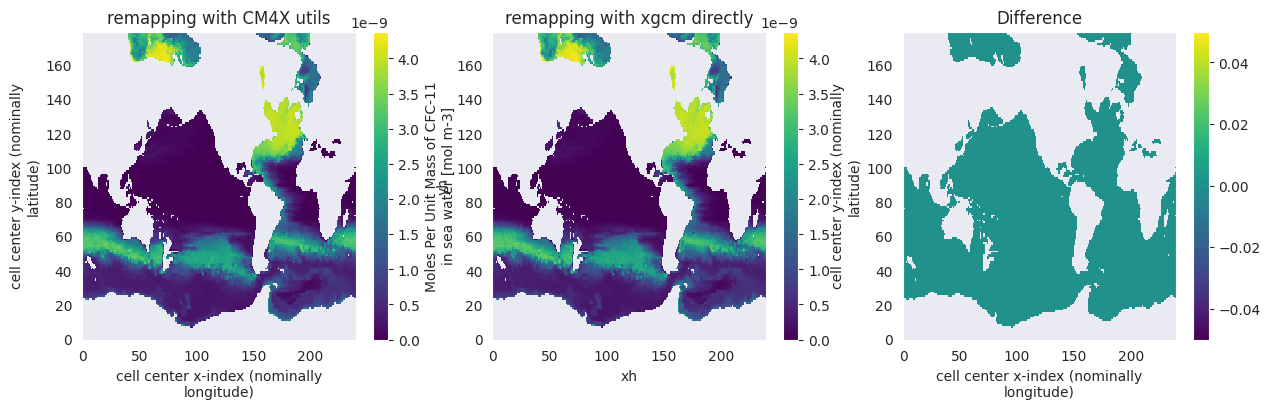

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

z_idx = 20
cfc11_by_depth_CM4Xutils_y1.isel(z_l = z_idx).plot(ax = ax[0])
ax[0].set_title("remapping with CM4X utils")
cfc11_by_depth_y1.isel(z = z_idx).plot(ax = ax[1])
ax[1].set_title("remapping with xgcm directly")

# sigma2_depth.plot.contourf(ax = ax[1])
difference = np.abs(cfc11_by_depth_CM4Xutils_y1.isel(z_l = z_idx) - cfc11_by_depth_y1.isel(z = z_idx))
(difference/ cfc11_by_depth_y1.isel(z = z_idx)).plot(ax = ax[2])
ax[2].set_title("Difference")
